# Defining gyrotropic materials

Here we demonstrate the usage of Tidy3D simulation software for modeling of gyrotropic materials, that is, materials with Hermitian permittivity tensors. Currently, this is achieved by using [fully anisotropic dieletric medium](../_autosummary/tidy3d.FullyAnisotropicMedium.html) option with anisymmetric conductivity tensor. Specifically, let us consider modeling a material with total complex permittivity tensor 
$$\varepsilon = \varepsilon_u + i \frac{\sigma_u}{\omega} + i \varepsilon_0 G,$$ 
where $\varepsilon_u$ and $\sigma_u$ are real symmetric matrices describing unperturbed permittivity and conductivity of the material, and $G$ is a real antisymmetric matrix representing the magneto-optic effect. That is, 
$$G = \begin{pmatrix} 0 & g_z & -g_y  \\ -g_z & 0 & g_x \\ g_y & -g_x & 0\end{pmatrix}$$
for a gyration vector $\boldsymbol{g} = \begin{pmatrix} g_x & g_y & g_z \end{pmatrix}$. Denoting the electromagnetic frequency of interest as $\omega_0$, we can approximate the complex permittivity of material in the vicinity of $\omega_0$ as $$\varepsilon \approx \varepsilon_u + i \frac{1}{\omega} \left( \sigma_u + \varepsilon_0 G \omega_0 \right).$$ 
Thus, the gyrotropic effect of a medium can be modeled by providing a modified conductivity tensor $\sigma = \sigma_u + \varepsilon_0 G \omega_0$ that contains both symmetric and antisymmetric parts. Note that because of this approximation, the simulation results will be most accurate in the vicinity of the frequency of interest $\omega_0$.

## Simulation setup

Let us now demonstrate simulation of plane wave propagation inside a gyrotropic material. Specifically, we will consider two simulations, one with $\boldsymbol{g} = 0$ and another one with $\boldsymbol{g} \neq 0$. In the first, reference, simulation the injected plane wave is expected to preserve its polarization, while in the second case the polarization of the injected pulse will undergo rotation due to the gyrotropic properties of the background medium. The rotation degree can be predicted by analytical expressions. In section [Results](#Results) we apply it to the results of the reference simulation and compare with the results of the gyrotropic simulation.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pylab as plt

# tidy3D import
import tidy3d as td
import tidy3d.web as web

We define an elongated simulation domain assuming wave propagation along $z$ direction and select sample frequencies in the vicinity of the wavelength of interest.

In [2]:
# simulation domain
sim_length = 10
sim_size = [0.1, 0.1, sim_length]

# central frequency
wvl_um = 1
freq0 = td.C_0 / wvl_um
fwidth = freq0 / 10
freqs = np.linspace(freq0 - fwidth, freq0 + fwidth, 5)

run_time = 10 / fwidth

Properties of the unperturbed material.

In [3]:
eps0 = 2
permittivity_unperturbed = np.diag((eps0, eps0, eps0))
conductivity_unperturbed = np.zeros((3, 3))

Gyration vector along the propagation axis.

In [4]:
g = (0, 0, 0.1)
G = np.array([[0, g[2], g[1]], [-g[2], 0, g[0]], [-g[1], -g[0], 0]])

Following the procedure outlined in the beginning of this tutorial we modify the material conductivity such that it accounts for material gyrotropic properties.

In [5]:
conductivity = conductivity_unperturbed + G * (2 * np.pi * freq0) * td.EPSILON_0

Now we define two materials: a simple [isotropic medium](../_autosummary/tidy3d.Medium.html) to use in a reference simulation and a [fully anisotropic medium](../_autosummary/tidy3d.FullyAnisotropicMedium.html) for modeling the magneto-optic effect.

In [6]:
medium_unperturbed = td.Medium(permittivity=eps0)
medium_gyrotropic = td.FullyAnisotropicMedium(permittivity=permittivity_unperturbed, conductivity=conductivity)

Given the simulation geometry we place PML boundary conditions along the propagation axis and periodic boundary conditions in the orthogonal directions

In [7]:
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary.pml(),
)

We will track field distribution along the propagation axis.

In [8]:
mnt_xz = td.FieldMonitor(
    center=(0, 0, 0),
    size=(0, 0, td.inf),
    freqs=freqs,
    name="freq_mnt_xz",
)

Since Tidy3D does not currently support injection of [unidirectional plane waves](../_autosummary/tidy3d.PlaneWave.html) into anisotropic material, we use [a uniform current source](../_autosummary/tidy3d.UniformCurrentSource.html) to initiate a planar (bidirectional) propagating pulse.

In [9]:
source = td.UniformCurrentSource(
    center=(0, 0, -sim_length/2.5),
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    polarization="Ex",
)

Use automatic grid discretization based on the requested number of steps per source wavelength.

In [10]:
grid_spec = td.GridSpec.auto(min_steps_per_wvl=30)

Combining defined above components we create two simulation, with and without gyrotropic effect.

In [11]:
# Propagation in an unperturbed medium
sim_unperturbed = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    medium=medium_unperturbed,
    sources=[source],
    monitors=[mnt_xz],
    run_time=run_time,
    boundary_spec=boundary_spec,
)

# Propagation in a gyrotropic medium
sim_gyrotropic = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    medium=medium_gyrotropic,
    sources=[source],
    monitors=[ mnt_xz],
    run_time=run_time,
    boundary_spec=boundary_spec,
)

Visualize simulation for setup confirmation.

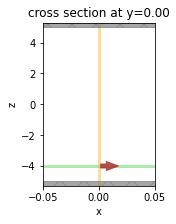

In [12]:
_, ax = plt.subplots(1, 1, figsize=(2, 3))
sim_gyrotropic.plot(y=0, ax=ax)
ax.set_aspect("auto")
plt.show()

## Results

Submit and run simulations on the server.

In [13]:
data_unperturbed = web.run(simulation=sim_unperturbed, task_name="gyrotropic_reference", path="data/simulation_data_gyrotropic_ref.hdf5", verbose=True)
data_gyrotropic = web.run(simulation=sim_gyrotropic, task_name="gyrotropic", path="data/simulation_data_gyrotropic.hdf5", verbose=True)

[16:57:08] Created task 'gyrotropic_reference' with task_id                                           ]8;id=280297;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=648278;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#186\186]8;;\
           'fdve-010efdb5-62aa-4da9-9fea-d51749934a32v1'.                                                          

           View task using web UI at                                                                  ]8;id=262213;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=670641;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=737339;https://tidy3d.simulation.cloud/workbench?taskId=fdve-010efdb5-62aa-4da9-9fea-d51749934a32v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=801779;https://tidy3d.simulation.cloud/workbench?taskId=fdve-010efdb5-62aa-4da9-9fea-d51749934a32v1\taskId]8;;\]8;id=737339;https://tidy3d.simulation.cloud/workbench?taskId=fdve-010efdb5-62aa-4da9-9fea-d51749934a32v1\=]8;;\]8;id=896405;https://tidy3d.simulation.cloud/workbench?taskId=fdve-010efdb5-62aa-4da9-9fea-d51749934a32v1\fdve]8;;\]8;id=737339;https://tidy3d.simulation.cloud/workbench?taskId=fdve-010efdb5-62aa-4da9-9fea-d51749934a32v1\-010efdb5-62aa-4da9-9fea-d51749934a3]8;;\              
           ]8;id=737339;https://tidy3d.simulation.cloud/workbench?taskId=fdve-010efdb5-62aa-4da9-9fea-d51749934a32v1\2v1']8;;\.                                                                                                   

Output()

[16:57:12] status = queued                                                                            ]8;id=312983;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=696617;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#321\321]8;;\

Output()

[16:57:19] status = preprocess                                                                        ]8;id=692133;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=164250;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#315\315]8;;\

[16:57:26] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=59344;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=165818;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=5599;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=182522;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=106736;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=543314;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#352\352]8;;\

Output()

[16:57:33] early shutoff detected, exiting.                                                           ]8;id=9010;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=639500;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=658888;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=324857;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#383\383]8;;\

Output()

[16:57:39] status = success                                                                           ]8;id=949882;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=603705;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#390\390]8;;\

Output()

[16:57:41] loading SimulationData from data/simulation_data_gyrotropic_ref.hdf5                       ]8;id=292714;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=716461;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#568\568]8;;\

[16:57:41] Created task 'gyrotropic' with task_id 'fdve-99c887ed-1681-492e-a374-2781ca415175v1'.      ]8;id=5782;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=523115;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=271043;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=229838;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=479434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99c887ed-1681-492e-a374-2781ca415175v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=986159;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99c887ed-1681-492e-a374-2781ca415175v1\taskId]8;;\]8;id=479434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99c887ed-1681-492e-a374-2781ca415175v1\=]8;;\]8;id=552398;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99c887ed-1681-492e-a374-2781ca415175v1\fdve]8;;\]8;id=479434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99c887ed-1681-492e-a374-2781ca415175v1\-99c887ed-1681-492e-a374-2781ca41517]8;;\              
           ]8;id=479434;https://tidy3d.simulation.cloud/workbench?taskId=fdve-99c887ed-1681-492e-a374-2781ca415175v1\5v1']8;;\.                                                                                                   

Output()

[16:57:43] status = queued                                                                            ]8;id=281099;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=153972;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#321\321]8;;\

Output()

[16:57:49] status = preprocess                                                                        ]8;id=217163;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=565806;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#315\315]8;;\

[16:57:56] Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=45614;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=302160;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=496209;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=609557;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#342\342]8;;\

           running solver                                                                             ]8;id=595407;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=598347;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#352\352]8;;\

Output()

[16:58:02] status = postprocess                                                                       ]8;id=137290;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=567582;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#383\383]8;;\

Output()

[16:58:08] status = success                                                                           ]8;id=945935;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=48297;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#390\390]8;;\

Output()

[16:58:09] loading SimulationData from data/simulation_data_gyrotropic.hdf5                           ]8;id=668674;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=389113;file:///home/daniil/Code/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#568\568]8;;\

Now we compare the simulation results to analytically predicted behavior. It is known that in the gyrotropic medium propagation along gyration axis allows two circularly polarized normal modes with propagation constants given by
$$n_{\pm} = \sqrt{n^2 \pm G}$$
and the rotatory power (rotation angle per unit length) of the medium is given by 
$$\rho = \frac{\pi}{\lambda_0} \left(n_- - n_+\right).$$

First we consider central frequency for which we expect simulation results to be the most accurate.

In [14]:
freq_ind = len(freqs) // 2

To obtain reference field distribution we extract numerical data from the reference simulation and apply rotation of polarization as predicted by the theory.

In [15]:
# reference (constant polarization) wave propagation
Ex_ref = (
    data_unperturbed["freq_mnt_xz"]
    .field_components["Ex"]
    .isel({"f": freq_ind, "x": 0, "y": 0})
)

# predicted rotatory power at chosen wavelength
wvl = td.C_0 / freqs[freq_ind]
n_minus = np.sqrt(eps0 - g[2])
n_plus = np.sqrt(eps0 + g[2])
rho = np.pi / wvl * (n_minus - n_plus)

# rotation factor along propagation direction
coord = Ex_ref.coords["z"]
src_coord = source.center[2]
dist = coord.data - src_coord
factor_x = np.cos(rho * dist).real
factor_y = -np.sin(rho * abs(dist)).real

# rotated polarizations
Ex_theory = Ex_ref * factor_x
Ey_theory = Ex_ref * factor_y

Extract simulation data at the chosen frequency.

In [16]:
Ex_num = (
    data_gyrotropic["freq_mnt_xz"]
    .field_components["Ex"]
    .isel({"f": freq_ind, "x": 0, "y": 0})
)

Ey_num = (
    data_gyrotropic["freq_mnt_xz"]
    .field_components["Ey"]
    .isel({"f": freq_ind, "x": 0, "y": 0})
)

Plot the comparison.

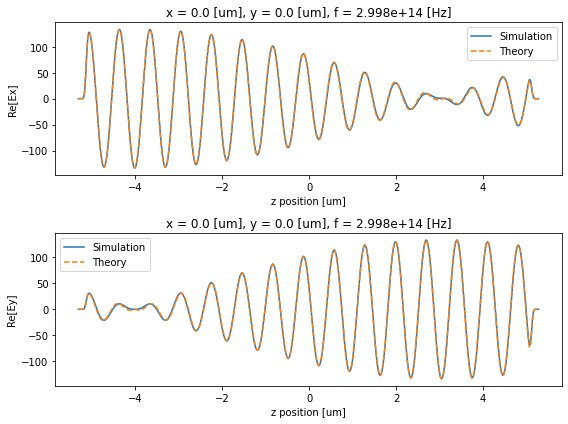

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
Ex_num.real.plot(ax=ax[0])
Ex_theory.real.plot(ax=ax[0], ls="--")
ax[0].set_ylabel("Re[Ex]")
ax[0].legend(["Simulation", "Theory"])

Ey_num.real.plot(ax=ax[1])
Ey_theory.real.plot(ax=ax[1], ls="--")
ax[1].set_ylabel("Re[Ey]")
ax[1].legend(["Simulation", "Theory"])

plt.tight_layout()
plt.show()

As one can see the simulation results for magneto-optic effect matches very closely the predicted behavior. Note that this comparison is made at the central wavelength. If we repeat the same comparison away from central wavelength the accuracy of simulation results will degrade because of the approximations made in defining properties of the gyrotropic medium.

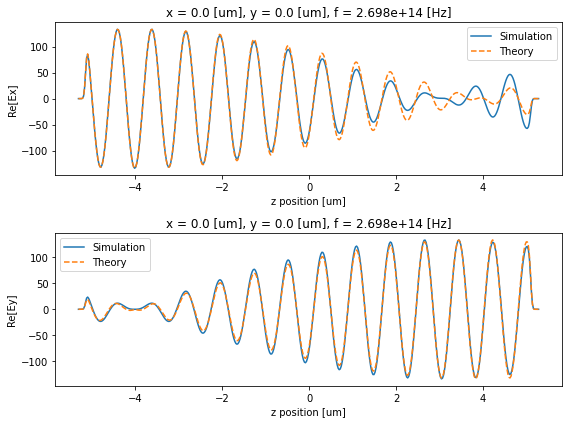

In [18]:
# choose frequency index (out of 5)
freq_ind = 0

# reference (constant polarization) wave propagation
Ex_ref = (
    data_unperturbed["freq_mnt_xz"]
    .field_components["Ex"]
    .isel({"f": freq_ind, "x": 0, "y": 0})
)

# predicted rotatory power at chosen wavelength
wvl = td.C_0 / freqs[freq_ind]
n_minus = np.sqrt(eps0 - g[2])
n_plus = np.sqrt(eps0 + g[2])
rho = np.pi / wvl * (n_minus - n_plus)

# rotation factor along propagation direction
coord = Ex_ref.coords["z"]
src_coord = source.center[2]
dist = coord.data - src_coord
factor_x = np.cos(rho * dist).real
factor_y = -np.sin(rho * abs(dist)).real

# rotated polarizations
Ex_theory = Ex_ref * factor_x
Ey_theory = Ex_ref * factor_y

# extract simulation data at the chosen frequency
Ex_num = (
    data_gyrotropic["freq_mnt_xz"]
    .field_components["Ex"]
    .isel({"f": freq_ind, "x": 0, "y": 0})
)

Ey_num = (
    data_gyrotropic["freq_mnt_xz"]
    .field_components["Ey"]
    .isel({"f": freq_ind, "x": 0, "y": 0})
)

# plot comparison
fig, ax = plt.subplots(2, 1, figsize=(8,6))
Ex_num.real.plot(ax=ax[0])
Ex_theory.real.plot(ax=ax[0], ls="--")
ax[0].set_ylabel("Re[Ex]")
ax[0].legend(["Simulation", "Theory"])

Ey_num.real.plot(ax=ax[1])
Ey_theory.real.plot(ax=ax[1], ls="--")
ax[1].set_ylabel("Re[Ey]")
ax[1].legend(["Simulation", "Theory"])

plt.tight_layout()
plt.show()

Gyrotropic materials are only a special type of the [FullyAnisotropicMedium](../_autosummary/tidy3d.FullyAnisotropicMedium.html). For more general cases, see the tutorial on [defining fully anisotropic materials](https://www.flexcompute.com/tidy3d/examples/notebooks/FullyAnisotropic/).